In [36]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [1]:
import root_numpy
import pandas
from utils import shrink_floats
import json

In [2]:
with open('./features.json', 'r') as f:
    features = json.load(f)

In [3]:
features

{u'CALO': [u'CaloBremMatch',
  u'CaloElectronMatch',
  u'CaloTrMatch',
  u'CaloTrajectoryL',
  u'CaloChargedSpd',
  u'CaloChargedPrs',
  u'CaloChargedEcal',
  u'CaloNeutralSpd',
  u'CaloNeutralPrs',
  u'CaloNeutralEcal',
  u'CaloSpdE',
  u'CaloPrsE',
  u'CaloEcalE',
  u'CaloHcalE',
  u'EcalPIDmu',
  u'HcalPIDmu',
  u'PrsPIDe',
  u'BremPIDe',
  u'EcalPIDe',
  u'HcalPIDe'],
 u'DLL': [u'CombDLLmu', u'CombDLLpi', u'CombDLLp', u'CombDLLe', u'CombDLLk'],
 u'RICH': [u'RichAboveMuThres',
  u'RichAboveElThres',
  u'RichAbovePiThres',
  u'RichAboveKaThres',
  u'RichAbovePrThres',
  u'RichUsedR1Gas',
  u'RichUsedR2Gas',
  u'RichDLLbt',
  u'RichDLLpi',
  u'RichDLLe',
  u'RichDLLp',
  u'RichDLLmu',
  u'RichDLLk'],
 u'acceptance': [u'InAccSpd',
  u'InAccPrs',
  u'InAccBrem',
  u'InAccEcal',
  u'InAccHcal',
  u'InAccMuon'],
 u'muon': [u'MuonNShared',
  u'MuonIsLooseMuon',
  u'MuonIsMuon',
  u'MuonBkgLL',
  u'MuonMuLL'],
 u'track': [u'TrackFitVeloChi2',
  u'TrackFitVeloNDoF',
  u'TrackFitMatchChi2',
 

In [4]:
data = pandas.DataFrame(root_numpy.root2array('../data/global_train.root', 'tree'))
shrink_floats(data)

In [5]:
data_test = pandas.DataFrame(root_numpy.root2array('../data/global_test.root', 'tree'))
shrink_floats(data_test)

In [6]:
from utils import compute_labels_and_weights, labels_names_correspondence

In [7]:
data['Signal'], _ = compute_labels_and_weights(data.MCParticleType.values)
data_test['Signal'], _ = compute_labels_and_weights(data_test.MCParticleType.values)

In [14]:
from scipy.stats import ks_2samp
for key, f_array in features.items():
    print key
    for value in f_array:
        print '\t', value
        for label, name in labels_names_correspondence.items():
            print "\t\t {name:10} KS: {ks:1.5f}".format(name=name, 
                                                        ks=ks_2samp(data.loc[data.Signal == label, value], 
                                                                    data_test.loc[data_test.Signal == label, value])[0])

muon
	MuonNShared
		 Ghost      KS: 0.00044
		 Electron   KS: 0.00064
		 Muon       KS: 0.00461
		 Pion       KS: 0.00025
		 Kaon       KS: 0.00033
		 Proton     KS: 0.00063
	MuonIsLooseMuon
		 Ghost      KS: 0.00019
		 Electron   KS: 0.00064
		 Muon       KS: 0.00461
		 Pion       KS: 0.00025
		 Kaon       KS: 0.00033
		 Proton     KS: 0.00063
	MuonIsMuon
		 Ghost      KS: 0.00053
		 Electron   KS: 0.00001
		 Muon       KS: 0.00463
		 Pion       KS: 0.00000
		 Kaon       KS: 0.00055
		 Proton     KS: 0.00045
	MuonBkgLL
		 Ghost      KS: 0.00036
		 Electron   KS: 0.00079
		 Muon       KS: 0.00507
		 Pion       KS: 0.00050
		 Kaon       KS: 0.00045
		 Proton     KS: 0.00064
	MuonMuLL
		 Ghost      KS: 0.00031
		 Electron   KS: 0.00072
		 Muon       KS: 0.00477
		 Pion       KS: 0.00046
		 Kaon       KS: 0.00045
		 Proton     KS: 0.00069
track
	TrackFitVeloChi2
		 Ghost      KS: 0.00244
		 Electron   KS: 0.00198
		 Muon       KS: 0.00245
		 Pion       KS: 0.00298
		 Kaon       KS: 0.0024

In [18]:
from sklearn.cross_validation import train_test_split

In [19]:
data1, data1_test = train_test_split(data, train_size=0.51, random_state=19)
data2, data2_test = train_test_split(data_test, train_size=0.51, random_state=19)

In [22]:
import numpy
features_origin = numpy.concatenate(features.values())

In [24]:
len(features_origin)

60

In [43]:
from decisiontrain import DecisionTrainClassifier
from rep.estimators import SklearnClassifier

In [45]:
%%time
d_train = pandas.concat([data1, data2])
d_train_label = numpy.array([0] * len(data1) + [1] * len(data2))
dt_particles = {}
for label, name in labels_names_correspondence.items():
    dt = SklearnClassifier(DecisionTrainClassifier(n_estimators=1000, learning_rate=0.05, n_threads=8),
                           features=features_origin)
    mask = d_train.Signal.values == label
    dt.fit(d_train[mask], d_train_label[mask])
    dt_particles[label] = dt

CPU times: user 16min 32s, sys: 6.49 s, total: 16min 39s
Wall time: 3min 26s


In [46]:
d_test = pandas.concat([data1_test, data2_test])
d_test_label = numpy.array([0] * len(data1_test) + [1] * len(data2_test))

In [48]:
reports = {}
from sklearn.metrics import roc_auc_score
for label, name in labels_names_correspondence.items():
    mask = d_test.Signal.values == label
    reports[label] = dt_particles[label].test_on(d_test[mask], d_test_label[mask])

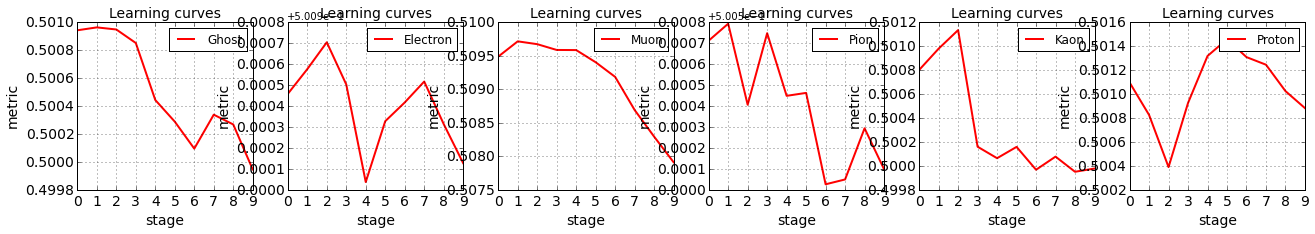

In [52]:
from rep.report.metrics import RocAuc
figure(figsize=(22, 3))
for label, name in labels_names_correspondence.items(): 
    subplot(1, 6, label + 1)
    lc = reports[label].learning_curve(RocAuc(), steps=1)
    lc.plot()
    legend([name])